In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr
import datetime
import time
import itertools

from VariationalNC.utils import *
from VariationalNC.train import *
from VariationalNC.Variational_layers import VariationalLinear, VariationalConv2d
from VariationalNC.Variational_utils import variational_estimator, ScaleMixtureGaussian

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# for plot figures
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)

torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible

training inputs shape:
(1800, 961)


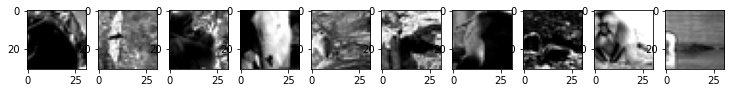

In [3]:
#load training data, number of stimuli: 1800, stimuli size: 961 (31x31)
#the maximum is 0.000255
training_inputs=np.load('Data_Antolik_et_al_2016/region1/training_inputs.npy')
#Rescaling，make the data range 0-1.0
training_inputs=training_inputs/255.0*1e6
#preporcess: center the data
#training_mean=np.mean(training_inputs)
#training_inputs=training_inputs-training_mean
print ('training inputs shape:')
print (training_inputs.shape)
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(np.reshape(training_inputs[ii],(31,31)),cmap='gray',vmin=0,vmax=1)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

training responses shape:
(1800, 103)


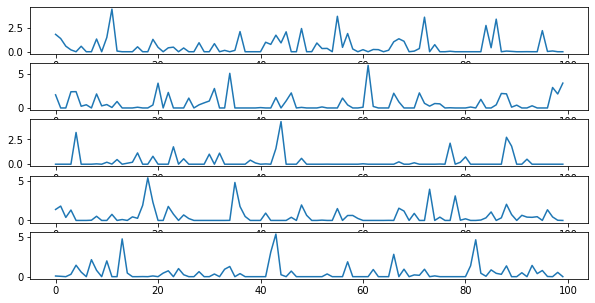

In [4]:
#load training data,number of stimuli: 1800, number of neurons: 103
training_set=np.load('Data_Antolik_et_al_2016/region1/training_set.npy')
#get sqrt of response
#reference: the effects of a square root transform on a Poisson distriuted quantity. (Thacker, 2001)
Flag_sqrt_response=False
if Flag_sqrt_response==True:
    training_set=np.sqrt(training_set)
print ('training responses shape:')
print (training_set.shape)
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(training_set[:100,ii])

test inputs shape:
(50, 961)


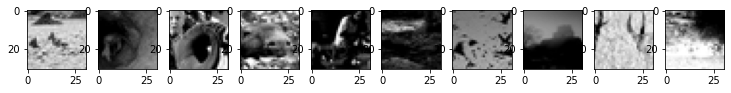

In [5]:
#load test data, number of stimuli: 50, stimuli size: 961 (31x31)
#the maximum is 0.000255
test_inputs=np.load('Data_Antolik_et_al_2016/region1/validation_inputs.npy')
#make the data range 0-1.0
test_inputs=test_inputs/255.0*1e6
#preporcess: center the data
#test_inputs=test_inputs-training_mean
print ('test inputs shape:')
print (test_inputs.shape)
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(np.reshape(test_inputs[ii],(31,31)),cmap='gray',vmin=0,vmax=1)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

test responses shape:
(50, 103)


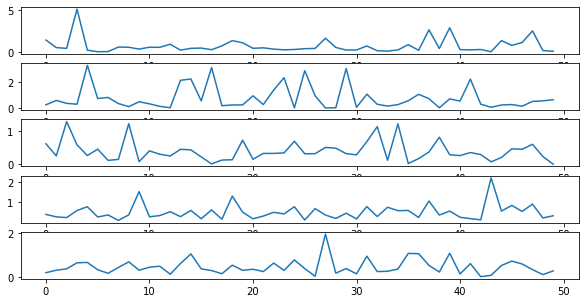

In [6]:
#load test data, number of stimuli: 50, number of neurons: 103
test_set=np.load('Data_Antolik_et_al_2016/region1/validation_set.npy')
#get sqrt of response
#reference: the effects of a square root transform on a Poisson distriuted quantity. (Thacker, 2001)
if Flag_sqrt_response==True:
    test_set=np.sqrt(test_set)
print ('test responses shape:')
print (test_set.shape)
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(test_set[:,ii])
    #axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [7]:
train_mean=np.mean(training_inputs[:1600])
train_std=np.std(training_inputs[:1600],ddof=1)

In [8]:
print(training_inputs.shape)
print(train_std)
print(train_mean)

(1800, 961)
0.3115977300890251
0.4926736038848419


In [9]:
#split original training data into two parts, training loader: 1600, validation loader: 200
#make the dataset suitable for pytorch
train_loader=[]
for ii in range(0,1600,800):
    temp0=training_inputs[ii:ii+800]-train_mean
    temp0=np.reshape(temp0,(800,31,31))
    temp0=np.expand_dims(temp0,axis=1)
    temp1=training_set[ii:ii+800]#100*103(neurons)
    temp=(temp0,temp1)
    train_loader.append(temp)

temp0=training_inputs[1600:]-train_mean
temp0=np.reshape(temp0,(200,31,31))
temp0=np.expand_dims(temp0,axis=1)
temp1=training_set[1600:]#200*103(neurons)
val_loader=(temp0,temp1)

temp0=np.copy(test_inputs)-train_mean
temp0=np.reshape(temp0,(50,31,31))
temp0=np.expand_dims(temp0,axis=1)
temp1=np.copy(test_set)#50*103(neurons)
test_loader=(temp0,temp1)

print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)

length of train_loader:
2
shape of train_loader[0][0]:
(800, 1, 31, 31)
shape of train_loader[0][1]:
(800, 103)
shape of val_loader[0]:
(200, 1, 31, 31)
shape of val_loader[1]:
(200, 103)
shape of test_loader[0]:
(50, 1, 31, 31)
shape of test_loader[1]:
(50, 103)


In [11]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 50
LR=0.0001
L2=0.0
TEST_SAMPLES = 10

## Models

In [12]:
#
class VanillaCNN(nn.Module):
    def __init__(self,numoffea=48):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=17*17 #size of feature
        self.numofneuron=103 #number of neurons
        #
        self.conv1 = nn.Conv2d(1,24,kernel_size=9,stride=1)#24,23*23
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(24,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(24*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
    def forward(self, x):
        encoded = F.relu(self.conv1(x))#24,23*23
        encoded = F.relu(self.conv2(encoded))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded)) #use exp instead of relu
        return encoded
#
@variational_estimator
class VariationalCNN(nn.Module):
    def __init__(self,numoffea=48,PI=0.5, SIGMA_1=1, SIGMA_2=0.00247875):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=17*17 #size of feature
        self.numofneuron=103 #number of neurons
        self.conv1=VariationalConv2d(1,24,kernel_size=(9,9),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#24,23*23
        self.conv2=VariationalConv2d(24,self.numoffea,kernel_size=(7,7),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#48,17*17
        self.fc1  =VariationalLinear(self.numoffea*self.sizeoffea,self.numofneuron,PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)
    def forward(self, x, sampleFlag=False):
        encoded = F.relu(self.conv1(x, sampleFlag))#24,23*23
        encoded = F.relu(self.conv2(encoded, sampleFlag))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded, sampleFlag)) #use exp instead of relu
        return encoded
    

class VanillaCNN_Dropout(nn.Module):
    def __init__(self,numoffea=48,p=0.5):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=17*17 #size of feature
        self.numofneuron=103 #number of neurons
        #self.dropout1=nn.Dropout(p=p1)
        #self.dropout2=nn.Dropout(p=p2)
        self.dropout=nn.Dropout(p=p)
        #
        self.conv1 = nn.Conv2d(1,24,kernel_size=9,stride=1)
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(24,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(24*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
    def forward(self, x):
        encoded = F.relu(self.conv1(x)) #24,23*23
        encoded = self.dropout(encoded)
        encoded = F.relu(self.conv2(encoded))#48,17*17
        encoded = self.dropout(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = self.fc1(encoded)
        encoded = self.dropout(encoded)
        encoded = torch.exp(encoded) #use exp instead of relu
        return encoded

## CNN with the best regularizations 

In [ ]:
#training VanillaCNN(), record training and validation loss
tempmodels=['VanillaCNN']
LR=0.0003     
EPOCH=200
train_num=len(train_loader)
alphas_1=[0.0,1,10,100,1000,10000,100000]     #conv1
alphas_2=[0.0,0.00001,0.0001,0.001,0.01,0.1,1]  #conv2
betas=[0.0,1,3,10,30,100,300]               #fl
vbeta=None
best_epochs=np.zeros((len(betas)*len(alphas_1)*len(alphas_2))) # for each train_num, the epoch when achieving best val CC
best_valloss=np.zeros((len(betas)*len(alphas_1)*len(alphas_2))) # for each train_num, the best val CC
train_val_loss=np.zeros((2,(len(betas)*len(alphas_1)*len(alphas_2)),EPOCH))
qq=0
#
for ii in range(len(alphas_1)):
    for jj in range(len(alphas_2)):
        for kk in range(len(betas)):
            modelname=str(qq)
            torch.manual_seed(1)    # reproducible
            torch.cuda.manual_seed(1)
            tempmodel = globals()[tempmodels[0]]()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            trainlosses,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE_regularizaion_2conv,\
                    alpha1=alphas_1[ii],alpha2=alphas_2[jj],beta=betas[kk],vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
            train_val_loss[0,qq],train_val_loss[1,qq]=trainlosses,vallosses
            del tempmodel
            torch.cuda.empty_cache()
            best_epochs[qq]  = np.argmax(vallosses)
            best_valloss[qq] = np.max(vallosses)
            print ('{}\n'.format(best_valloss[qq]))
            fig,ax=plt.subplots()
            ax.plot(vallosses)
            qq=qq+1
#
temp2=np.reshape(np.array(best_valloss),(7,7,7))
print(temp2)
best_kk=int(np.argmax(best_valloss))
best_a,yyy=divmod(best_kk,len(alphas_2)*len(betas))
best_b, best_c=divmod(yyy,len(betas))
best_alpha1=alphas_1[best_a]
best_alpha2=alphas_2[best_b]
best_beta=betas[best_c]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best alpha1: {} Best alpha2: {}  Best beta: {} and Epoch:{}'.format(best_alpha1,best_alpha2,best_beta,best_ep))
best_ep = best_ep + 1
modelname=str(1)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel = globals()[tempmodels[0]]()
optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
trainlosses,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:train_num],optimizer,device,best_ep,Ploss_L2L1_SE_regularizaion_2conv,\
                alpha1=best_alpha1,alpha2=best_alpha2,beta=best_beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
# RF_fl=vis_model_fl(tempmodel,device_cpu,(1,1,31,31))
# RF_fl_np=RF_fl.cpu().data.numpy()
# # RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
# nrows,ncols=1,20
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
# for ii in range(20):
#     temp=RF_fl_np[ii,0]
#     tempmax=np.max(np.abs(temp))
#     axes[ii].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
#     axes[ii].grid(False)#axes[ii,jj].axis('tight')
#     axes[ii].set_xticks([])
#     axes[ii].set_yticks([])
del tempmodel
torch.cuda.empty_cache()

In [21]:
#np.save('out_20211216/CNN_regularizations_train_val_loss.npy', train_val_loss)

In [51]:
train_val_loss=np.load('out_20211216/CNN_regularizations_train_val_loss.npy')
print(np.max(train_val_loss[1]))
print(np.max(train_val_loss[1,227]))

0.2913603063238942
0.2913603063238942


## CNN with MC dropout

In [ ]:
tempmodels=['VanillaCNN_Dropout']   #MC dropout
LRs=0.0003     
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=None
drop_out_num=100
dropout_p=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
train_val_loss=np.zeros((2,len(dropout_p),EPOCH))
best_epochs=np.zeros(len(dropout_p)) 
best_valloss=np.zeros(len(dropout_p)) 
for ii in range(len(dropout_p)):
    model_parameters = {'p':dropout_p[ii]}
    modelname=str(ii)
    torch.manual_seed(1)    # reproducible
    torch.cuda.manual_seed(1)
    tempmodel = globals()[tempmodels[0]](**model_parameters)
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LRs,weight_decay=0.0)
    trainlosses,vallosses=model_train_drop_out(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    drop_out_num,alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
    train_val_loss[0,ii],train_val_loss[1,ii]=trainlosses,vallosses
    del tempmodel
    torch.cuda.empty_cache()
    best_epochs[ii]  = np.argmax(vallosses)
    best_valloss[ii] = np.max(vallosses)
    print ('{}\n'.format(best_valloss[ii]))
    fig,ax=plt.subplots()
    ax.plot(vallosses)
    
temp2=np.reshape(np.array(best_valloss),(10,1))
print(temp2) 

In [57]:
#np.save('out_20211216/CNN_MCdropout_train_val_loss_defaults.npy', train_val_loss)

0.3020671173045429


## Tune the best beta

In [12]:
tempmodels=['VanillaCNN','VariationalCNN','VariationalCNN','VariationalCNN','VariationalCNN','VariationalCNN','VariationalCNN']
LR=0.0003
EPOCH=200
train_nums=len(train_loader)  
alpha=0
beta=0
vbetas=[None,0.01,0.03, 0.1, 0.3, 1.0, 3.0]
train_val_loss=np.zeros((2,len(tempmodels),EPOCH)) # 2: train and val loss
#
for ii in range(len(tempmodels)):
    modelname=str(1)
    torch.manual_seed(1)    # reproducible
    torch.cuda.manual_seed(1)
    tempmodel = globals()[tempmodels[ii]]() #tempmodels[ii]
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
    #temp=model_train(tempmodel,train_loader,optimizer,device,50,Ploss_L2L1_SE,alpha=None,beta=None)
    trainlosses,vallosses=model_train(tempmodel,train_loader[:train_nums],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    alpha=alpha,beta=beta,vbeta=vbetas[ii],earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
    train_val_loss[0,ii],train_val_loss[1,ii]=trainlosses,vallosses
    #modeltrainloss.append(temp)
    #torch.save(tempmodel.state_dict(), './out_20200810/VariationalLN_SimulationData_'+modelname+'.pth')
    #temp=model_val(tempmodel,val_loader,20,device_cpu,loss_mse)
    #modelvalloss.append(temp)
    #release gpu memory
    del tempmodel
    torch.cuda.empty_cache()
#
print (train_val_loss.shape)

2022-01-21 17:50:32.105395
Epoch: 199 val loss: 0.0913, finish training!
2022-01-21 17:51:02.709603
2022-01-21 17:51:02.835545
Epoch: 199 val loss: 0.2391, finish training!
2022-01-21 17:51:53.284461
2022-01-21 17:51:53.359951
Epoch: 199 val loss: 0.2494, finish training!
2022-01-21 17:52:43.921101
2022-01-21 17:52:43.987367
Epoch: 199 val loss: 0.2645, finish training!
2022-01-21 17:53:34.271343
2022-01-21 17:53:34.319495
Epoch: 199 val loss: 0.2769, finish training!
2022-01-21 17:54:25.156476
2022-01-21 17:54:25.230077
Epoch: 199 val loss: 0.2252, finish training!
2022-01-21 17:55:15.661459
2022-01-21 17:55:15.735077
Epoch: 199 val loss: 0.1409, finish training!
2022-01-21 17:56:06.197390
(2, 7, 200)


In [33]:
#np.save('out_20211216/CNN_train_val_loss_beta.npy', train_val_loss)

In [13]:
train_val_loss=np.load('out_20211216/CNN_train_val_loss_beta.npy')
print (train_val_loss.shape)
print(np.max(train_val_loss[1,0]))
print(np.max(train_val_loss[1,1]))
print(np.max(train_val_loss[1,2]))
print(np.max(train_val_loss[1,3]))
print(np.max(train_val_loss[1,4]))
print(np.max(train_val_loss[1,5]))
print(np.max(train_val_loss[1,6]))

(2, 7, 200)
0.2701233206360906
0.28459366886707843
0.2852866752177559
0.29145699881381915
0.28528818385655214
0.2312745169962677
0.1425927386779279


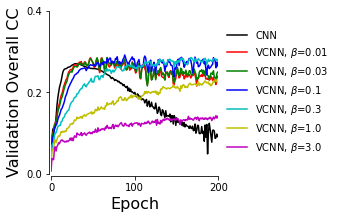

In [15]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss[1,0,:],color='k',linestyle='-',label='CNN')
ax.plot(train_val_loss[1,1,:],color='r',linestyle='-',label='VCNN, $\\beta$=0.01')
ax.plot(train_val_loss[1,2,:],color='g',linestyle='-',label='VCNN, $\\beta$=0.03')
ax.plot(train_val_loss[1,3,:],color='b',linestyle='-',label='VCNN, $\\beta$=0.1')
ax.plot(train_val_loss[1,4,:],color='c',linestyle='-',label='VCNN, $\\beta$=0.3')
ax.plot(train_val_loss[1,5,:],color='y',linestyle='-',label='VCNN, $\\beta$=1.0')
ax.plot(train_val_loss[1,6,:],color='m',linestyle='-',label='VCNN, $\\beta$=3.0')
#for ii in range(len(lossweights)):
#    ax.plot(train_val_loss[1,3,:100],color=colors[ii],label='{}'.format(lossweights[ii]))
ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0.0, 0.4])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0,0.2, 0.4])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Validation Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/VariationalCNN_SimulationData_seed_1_valloss_beta.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

## Test different prior distribution
mixture of Gaussian, Gaussian with small std, Gaussian with large std

In [ ]:
tempmodels=['VariationalCNN']
LR=0.0003
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=0.1
pis = [0.5,1]    
sigma1s = [1, 10, 100]
sigma2s=[0.04978706, 0.00247875, 0.00012341]

train_val_loss=np.zeros((2,(len(pis)*len(sigma1s)*len(sigma2s)),EPOCH))
best_epochs=np.zeros((len(pis)*len(sigma1s)*len(sigma2s))) # for each mixture, the epoch when achieving best val CC
best_valloss=np.zeros((len(pis)*len(sigma1s)*len(sigma2s))) # for each mixture, the best val CC
kk=0
for pi in pis:
    for s1 in sigma1s:
        for s2 in sigma2s:
            model_parameters = {'PI':pi, 'SIGMA_1':s1, 'SIGMA_2':s2}
            modelname=str(kk)
            torch.manual_seed(1)    # reproducible
            torch.cuda.manual_seed(1)
            tempmodel = globals()[tempmodels[0]](**model_parameters)
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            trainlosses,vallosses=model_train(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                                alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
            train_val_loss[0,kk],train_val_loss[1,kk]=trainlosses,vallosses
            del tempmodel
            torch.cuda.empty_cache()
            best_epochs[kk]= np.argmax(vallosses)
            best_valloss [kk]= np.max(vallosses)
            print ('{}\n'.format(best_valloss[kk]))
            fig,ax=plt.subplots()
            ax.plot(vallosses)
            kk=kk+1
            
temp2=np.reshape(np.array(best_valloss),(3,3,3))
print(temp2)            
best_kk=int(np.argmax(best_valloss))
best_a,aaa=divmod(best_kk,len(sigma1s)*len(sigma2s))
best_b,bbb=divmod(aaa,len(sigma2s))
best_pi=pis[best_a]
best_sigma1=sigma1s[best_b]
best_sigma2=sigma2s[bbb]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best pi: {} Best sigma1: {} Best sigma2: {} and Best epoch: {} '.format(best_pi, best_sigma1,best_sigma2,best_ep))


In [15]:
temp2=np.reshape(np.array(best_valloss),(2,3,3))
print(temp2)            
best_kk=int(np.argmax(best_valloss))
best_a,aaa=divmod(best_kk,len(sigma1s)*len(sigma2s))
best_b,bbb=divmod(aaa,len(sigma2s))
best_pi=pis[best_a]
best_sigma1=sigma1s[best_b]
best_sigma2=sigma2s[bbb]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best pi: {} Best sigma1: {} Best sigma2: {} and Best epoch: {} '.format(best_pi, best_sigma1,best_sigma2,best_ep))


[[[0.2844793  0.29145118 0.2902125 ]
  [0.28448034 0.28994804 0.29000281]
  [0.28447728 0.28970146 0.28544161]]

 [[0.28474159 0.28474159 0.28474159]
  [0.28475446 0.28475446 0.28475446]
  [0.28475598 0.28475598 0.28475598]]]
Best pi: 0.5 Best sigma1: 1 Best sigma2: 0.00247875 and Best epoch: 88 


In [13]:
best_kk=int(np.argmax(best_valloss))
best_a,aaa=divmod(best_kk,len(sigma1s)*len(sigma2s))
best_b,bbb=divmod(aaa,len(sigma2s))
best_pi=pis[best_a]
best_sigma1=sigma1s[best_b]
best_sigma2=sigma2s[bbb]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best pi: {} Best sigma1: {} Best sigma2: {} and Best epoch: {} '.format(best_pi, best_sigma1,best_sigma2,best_ep))

Best pi: 0.5 Best sigma1: 1 Best sigma2: 0.00012341 and Best epoch: 176 


In [ ]:
#np.save('out_20211216/VCNN_train_val_loss_mixture_Gaussian_defaults.npy', train_val_loss)

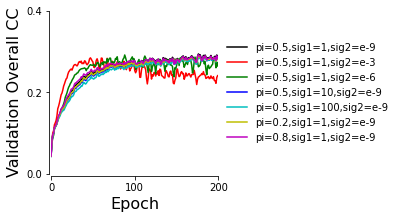

In [39]:
train_val_loss=np.load('out_20211216/VCNN_train_val_loss_mixture_Gaussian_defaults.npy')
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss[1,11,:],color='k',linestyle='-',label='pi=0.5,sig1=1,sig2=e-9')
ax.plot(train_val_loss[1,9,:],color='r',linestyle='-',label='pi=0.5,sig1=1,sig2=e-3')
ax.plot(train_val_loss[1,10,:],color='g',linestyle='-',label='pi=0.5,sig1=1,sig2=e-6')
ax.plot(train_val_loss[1,14,:],color='b',linestyle='-',label='pi=0.5,sig1=10,sig2=e-9')
ax.plot(train_val_loss[1,17,:],color='c',linestyle='-',label='pi=0.5,sig1=100,sig2=e-9')
ax.plot(train_val_loss[1,2,:],color='y',linestyle='-',label='pi=0.2,sig1=1,sig2=e-9')
ax.plot(train_val_loss[1,20,:],color='m',linestyle='-',label='pi=0.8,sig1=1,sig2=e-9')

ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0.0, 0.4])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0, 0.2, 0.4])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Validation Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/mixture_Gaussian_train_val_loss_VCNN_default.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

## Test different sampling times

2022-01-21 22:25:19.574348
Epoch: 199 val loss: 0.2802, finish training!
2022-01-21 22:25:51.533648
0.29757807096377714

2022-01-21 22:25:51.608454
Epoch: 199 val loss: 0.2645, finish training!
2022-01-21 22:26:42.206357
0.29145699881381915

2022-01-21 22:26:42.320827
Epoch: 199 val loss: 0.2672, finish training!
2022-01-21 22:28:11.784988
0.2910855829872768

2022-01-21 22:28:11.950674
Epoch: 199 val loss: 0.2578, finish training!
2022-01-21 22:30:58.710147
0.28422668760348185

2022-01-21 22:30:58.838480
Epoch: 199 val loss: 0.2351, finish training!
2022-01-21 22:36:14.782129
0.2888651716560649

[[0.29757807]
 [0.291457  ]
 [0.29108558]
 [0.28422669]
 [0.28886517]]
Best sampling_num: 1 and Epoch:123


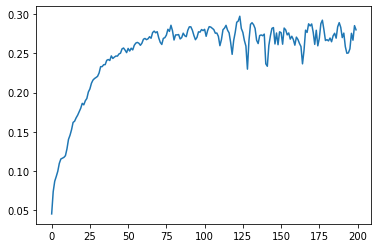

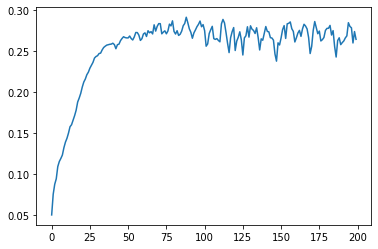

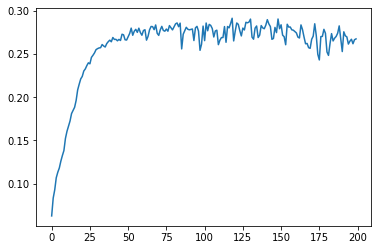

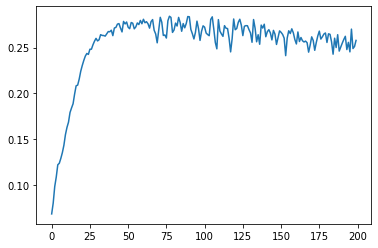

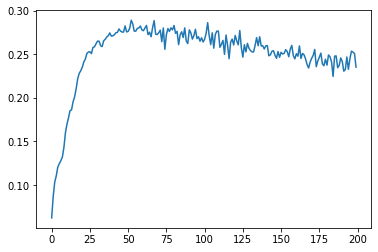

In [19]:
tempmodels=['VariationalCNN']
LR=0.0003
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=0.1
sampling_number=[1,2,4,8,16]
train_val_loss=np.zeros((2,len(sampling_number),EPOCH))
best_epochs=np.zeros((len(sampling_number)))
best_valloss=np.zeros((len(sampling_number)))
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 0.00247875}
for ii in range(len(sampling_number)):
    modelname=str(1)
    torch.manual_seed(1)    # reproducible
    torch.cuda.manual_seed(1)
    tempmodel = globals()[tempmodels[0]](**model_parameters)
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
    trainlosses,vallosses=model_train_sample_num(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                        alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False,sampling_num=sampling_number[ii])
    train_val_loss[0,ii],train_val_loss[1,ii]=trainlosses,vallosses
    del tempmodel
    torch.cuda.empty_cache()
    best_epochs[ii]  = np.argmax(vallosses)
    best_valloss[ii] = np.max(vallosses)
    print ('{}\n'.format(best_valloss[ii]))
    fig,ax=plt.subplots()
    ax.plot(vallosses)

temp2=np.reshape(np.array(best_valloss),(5,1))
print(temp2) 
best_sampling_num= sampling_number[np.argmax(best_valloss)]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best sampling_num: {} and Epoch:{}'.format(best_sampling_num,best_ep))

In [20]:
# np.save('out_20211216/VCNN_train_val_loss_sample_num.npy',train_val_loss)

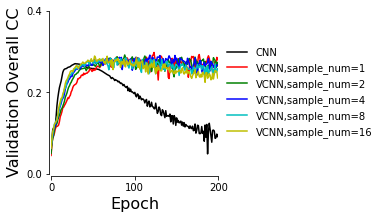

In [48]:
train_val_loss=np.load('out_20211216/VCNN_train_val_loss_sample_num.npy')
train_val_loss_CNN=np.load('out_20211216/CNN_train_val_loss_beta.npy')
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss_CNN[1,0,:],color='k',linestyle='-',label='CNN')
ax.plot(train_val_loss[1,0,:],color='r',linestyle='-',label='VCNN,sample_num=1')
ax.plot(train_val_loss[1,1,:],color='g',linestyle='-',label='VCNN,sample_num=2')
ax.plot(train_val_loss[1,2,:],color='b',linestyle='-',label='VCNN,sample_num=4')
ax.plot(train_val_loss[1,3,:],color='c',linestyle='-',label='VCNN,sample_num=8')
ax.plot(train_val_loss[1,4,:],color='y',linestyle='-',label='VCNN,sample_num=16')

ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0, 0.4])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0,0.2,0.4])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Validation Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/VCNN_seed_1_train_val_loss_sample_num.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

## CNN with regularizations vs. best varitionalCNN vs. CNN with dropout

#### Validation loss against epoch number

0.2913603063238942
0.29757807096377714
0.3020671173045429
0.2913603063238942
0.29145699881381915
0.3020671173045429


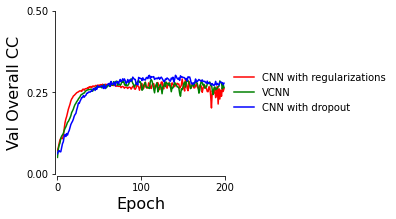

In [16]:
train_val_loss_CNN_L1L2=np.load('out_20211216/CNN_regularizations_train_val_loss.npy')
train_val_loss_VCNN=np.load('out_20211216/VCNN_train_val_loss_sample_num.npy')
train_val_loss_CNN_dropout=np.load('out_20211216/CNN_MCdropout_train_val_loss_defaults.npy')
print(np.max(train_val_loss_CNN_L1L2[1]))
print(np.max(train_val_loss_VCNN[1]))
print(np.max(train_val_loss_CNN_dropout[1]))
print(np.max(train_val_loss_CNN_L1L2[1,227]))
print(np.max(train_val_loss_VCNN[1,1]))
print(np.max(train_val_loss_CNN_dropout[1,7]))

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss_CNN_L1L2[1,227,:],color='r',linestyle='-',label='CNN with regularizations')
ax.plot(train_val_loss_VCNN[1,1,:],color='g',linestyle='-',label='VCNN')
ax.plot(train_val_loss_CNN_dropout[1,7,:],color='b',linestyle='-',label='CNN with dropout')
ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0.0,0.5])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0,0.25,0.5])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Val Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/Validation_loss_against_epoch_number_CNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')


#### Predictive performance against amount of training data
10 seeds, test data

In [ ]:
tempmodels=['VanillaCNN']  #without regularization
LR=0.0003
EPOCH=200
train_nums=len(train_loader)
alpha_1=0
alpha_2=0
beta=0
vbeta=None
seeds=np.arange(1,11)
test_losses=np.zeros((train_nums, len(seeds)))

for ii in range(len(train_loader)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:(ii+1)],optimizer,device,EPOCH,Ploss_L2L1_SE_regularizaion_2conv,\
                    alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]() #tempmodels[ii]
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_regularization_2conv(tempmodel,train_loader[:(ii+1)],optimizer,device,tempepoch,Ploss_L2L1_SE_regularizaion_2conv,\
                    alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_20211216/'+ tempmodel.__class__.__name__ +\
            'noregu__trainnum_' + str(ii)+ '_Antolik2016Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [13]:
#np.save('out_20211216/Predictive_performance_against_trainnums_Antolik2016Data_test_losses_CNN_noregu.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN']              #with regularization
LR=0.0003
EPOCH=200
train_nums=len(train_loader)
alpha_1=1000
alpha_2=0.01
beta=10
vbeta=None
seeds=np.arange(1,11)
test_losses=np.zeros((train_nums, len(seeds)))

for ii in range(len(train_loader)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:(ii+1)],optimizer,device,EPOCH,Ploss_L2L1_SE_regularizaion_2conv,\
                    alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]() #tempmodels[ii]
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_regularization_2conv(tempmodel,train_loader[:(ii+1)],optimizer,device,tempepoch,Ploss_L2L1_SE_regularizaion_2conv,\
                    alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_20211216/'+ tempmodel.__class__.__name__ +\
            '_trainnum_' + str(ii)+ '_Antolik2016Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [15]:
#np.save('out_20211216/Predictive_performance_against_trainnums_Antolik2016Data_test_losses_CNN.npy', test_losses)

In [16]:
tempmodels=['VariationalCNN']
LR=0.0003
EPOCH=200
train_nums=len(train_loader)
alpha=None
beta=None
vbetas=0.1
sampling_number=2
seeds=np.arange(1,11)
test_losses=np.zeros(((train_nums),len(seeds)))
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 0.00247875}

for ii in range(train_nums):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_sample_num(tempmodel,train_loader[:(ii+1)],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False,sampling_num=sampling_number)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_sample_num(tempmodel,train_loader[:(ii+1)],optimizer,device,tempepoch,Ploss_L2L1_SE,\
                alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False,sampling_num=sampling_number)
        torch.save(tempmodel.state_dict(), './out_20211216/'+ tempmodel.__class__.__name__ +\
            '_trainnum_' + str(ii) + '_Antolik2016Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2022-02-24 16:04:04.732838
Epoch: 199 val loss: 0.2364, finish training!
2022-02-24 16:04:31.599956
2022-02-24 16:04:31.651329
Epoch: 196 val loss: 0.2450, finish training!
2022-02-24 16:04:59.303718
Test loss: 0.5088919323782014

2022-02-24 16:04:59.520074
Epoch: 199 val loss: 0.2254, finish training!
2022-02-24 16:05:27.107605
2022-02-24 16:05:27.191591
Epoch: 187 val loss: 0.2325, finish training!
2022-02-24 16:05:51.846717
Test loss: 0.519757332698749

2022-02-24 16:05:52.052987
Epoch: 199 val loss: 0.2258, finish training!
2022-02-24 16:06:18.740715
2022-02-24 16:06:18.798767
Epoch: 171 val loss: 0.2385, finish training!
2022-02-24 16:06:42.308298
Test loss: 0.551602202685187

2022-02-24 16:06:42.504054
Epoch: 199 val loss: 0.2378, finish training!
2022-02-24 16:07:10.080649
2022-02-24 16:07:10.170749
Epoch: 190 val loss: 0.2406, finish training!
2022-02-24 16:07:38.740623
Test loss: 0.5329810504000126

2022-02-24 16:07:38.966447
Epoch: 199 val loss: 0.2172, finish training!
2022-

In [17]:
#np.save('out_20211216/Predictive_performance_against_trainnums_Antolik2016Data_test_losses.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN_Dropout']
LR=0.0003
EPOCH=200
train_nums=len(train_loader)
alpha=0
beta=0
vbetas=None
drop_out_num=100
model_parameters = {'p':0.7}
seeds=np.arange(1,11)
test_losses=np.zeros(((train_nums),len(seeds)))

for ii in range(train_nums):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_drop_out(tempmodel,train_loader[:(ii+1)],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    drop_out_num,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_drop_out(tempmodel,train_loader[:(ii+1)],optimizer,device,tempepoch,Ploss_L2L1_SE,\
                drop_out_num,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_20211216/'+ tempmodel.__class__.__name__ +\
             '_trainnum_' + str(ii) + '_Antolik2016Data_trainN_'+ '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val_drop_out(tempmodel,test_loader,device,drop_out_num,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [14]:
#np.save('out_20211216/CNN_dropout_Antolik2016Data_test_losses.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN_Dropout']
LR=0.0003
EPOCH=200
train_nums=len(train_loader)
alpha=0
beta=0
vbetas=None
drop_out_num=100
model_parameters = {'p':0.7}
seeds=np.arange(1,11)
test_losses=np.zeros(((train_nums),len(seeds)))

for ii in range(train_nums):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_drop_out(tempmodel,train_loader[:(ii+1)],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    drop_out_num,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_drop_out(tempmodel,train_loader[:(ii+1)],optimizer,device,tempepoch,Ploss_L2L1_SE,\
                drop_out_num,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_20211216/'+ tempmodel.__class__.__name__ +\
             'v1_trainnum_' + str(ii) + '_Antolik2016Data_trainN_'+ '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val_drop_out(tempmodel,test_loader,device,drop_out_num,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [19]:
#np.save('out_20211216/CNN_dropout_Antolik2016Data_test_losses_v1.npy', test_losses)

In [15]:
test_losses_CNN_noregu=np.load('out_20211216/Predictive_performance_against_trainnums_Antolik2016Data_test_losses_CNN_noregu.npy')
print (test_losses_CNN_noregu.shape)
test_losses_CNN_noregu_mean=np.mean(test_losses_CNN_noregu,axis=1)
test_losses_CNN_noregu_std =np.std (test_losses_CNN_noregu,axis=1,ddof=1)
print(np.max(test_losses_CNN_noregu_mean))
print(np.max(test_losses_CNN_noregu_std))

test_losses_CNN=np.load('out_20211216/Predictive_performance_against_trainnums_Antolik2016Data_test_losses_CNN.npy')
print (test_losses_CNN.shape)
test_losses_CNN_mean=np.mean(test_losses_CNN,axis=1)
test_losses_CNN_std =np.std (test_losses_CNN,axis=1,ddof=1)
print(np.max(test_losses_CNN_mean))
print(np.max(test_losses_CNN_std))

test_losses_VCNN=np.load('out_20211216/Predictive_performance_against_trainnums_Antolik2016Data_test_losses.npy')
print (test_losses_VCNN.shape)
test_losses_VCNN_mean=np.mean(test_losses_VCNN,axis=1)
test_losses_VCNN_std =np.std (test_losses_VCNN,axis=1,ddof=1)
print(np.max(test_losses_VCNN_mean))
print(np.max(test_losses_VCNN_std))

test_losses_CNN_dropout=np.load('out_20211216/CNN_dropout_Antolik2016Data_test_losses.npy')
print (test_losses_CNN_dropout.shape)
test_losses_CNN_dropout_mean=np.mean(test_losses_CNN_dropout,axis=1)
test_losses_CNN_dropout_std =np.std (test_losses_CNN_dropout,axis=1,ddof=1)
print(np.max(test_losses_CNN_dropout_mean))
print(np.max(test_losses_CNN_dropout_std))

(2, 10)
0.5271924371225174
0.035212429902717744
(2, 10)
0.543030132825073
0.022052684988503574
(2, 10)
0.5854259681804457
0.019234045306683135
(2, 10)
0.5770091522211265
0.03473534816485533


In [25]:
#test_losses_CNN_dropout_v1=np.load('out_20211216/CNN_dropout_Antolik2016Data_test_losses_v1.npy')
# print(test_losses_CNN_dropout_v1)
# print(test_losses_CNN_dropout)
# print(np.mean(test_losses_CNN_dropout_v1,axis=1))
# print(np.mean(test_losses_CNN_dropout,axis=1))
# print(np.mean(test_losses_VCNN,axis=1))

[[0.53470104 0.50528993 0.52626742 0.56849436 0.52866894 0.56492086
  0.52551749 0.51988506 0.55413842 0.52611821]
 [0.58180974 0.52556196 0.56029426 0.58078549 0.58662854 0.58744348
  0.60183733 0.57671763 0.60622546 0.57797842]]
[[0.53708903 0.46058478 0.465115   0.48070886 0.50373704 0.54478189
  0.54485547 0.55003371 0.53728464 0.50180747]
 [0.59062545 0.48861509 0.56661045 0.58962223 0.57011654 0.6072685
  0.57209451 0.59292523 0.59772104 0.59449249]]
[0.53540017 0.57852823]
[0.51259979 0.57700915]
[0.53102775 0.58542597]


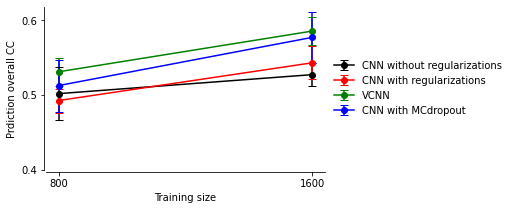

In [23]:
train_nums=[1,2]   
templabels=['800','1600']  
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
#ax.axhline(y=0.84,color='k',linestyle=':') #upper bound
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_noregu_mean,yerr=test_losses_CNN_noregu_std,\
            marker='o', color='k',linestyle='-',label='CNN without regularizations',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_mean,yerr=test_losses_CNN_std,\
            marker='o', color='r',linestyle='-',label='CNN with regularizations',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_VCNN_mean,yerr=test_losses_VCNN_std,\
            marker='o', color='g',linestyle='-',label='VCNN',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_dropout_mean,yerr=test_losses_CNN_dropout_std,\
            marker='o', color='b',linestyle='-',label='CNN with MCdropout',alpha=1, capsize=4)

ax.set_xticks(np.arange(len(train_nums)).tolist())
ax.set_yticks([0.4,0.5,0.6])
#ax.set_ylim(ymin=0.5)
ax.set_xticklabels(templabels)
ax.set_xlabel('Training size')
ax.set_ylabel('Prdiction overall CC')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/Predictive_performance_against_trainingSize_allSeeds_testCC_CNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

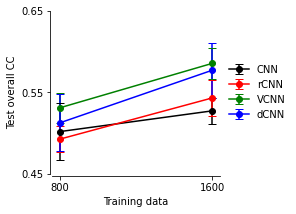

In [16]:
train_nums=[1,2]   
templabels=['800','1600']  
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
#ax.axhline(y=0.84,color='k',linestyle=':') #upper bound
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_noregu_mean,yerr=test_losses_CNN_noregu_std,\
            marker='o', color='k',linestyle='-',label='CNN',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_mean,yerr=test_losses_CNN_std,\
            marker='o', color='r',linestyle='-',label='rCNN',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_VCNN_mean,yerr=test_losses_VCNN_std,\
            marker='o', color='g',linestyle='-',label='VCNN',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_dropout_mean,yerr=test_losses_CNN_dropout_std,\
            marker='o', color='b',linestyle='-',label='dCNN',alpha=1, capsize=4)

ax.set_xticks(np.arange(len(train_nums)).tolist())
ax.set_yticks([0.45,0.55,0.65])
#ax.set_ylim(ymin=0.5)
ax.set_xticklabels(templabels)
ax.set_xlabel('Training data')
ax.set_ylabel('Test overall CC')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/Predictive_performance_against_trainingSize_allSeeds_testCC_CNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

#### Predictive response with std

In [12]:
Neurons=[1,56]

(50, 103)
(50, 103)


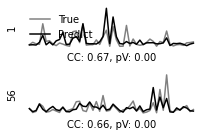

In [55]:
#no regu
tempmodel= VanillaCNN()
tempmodel.load_state_dict(torch.load('./out_20211216/VanillaCNNnoregu__trainnum_1_Antolik2016Data_trainN__seed_0.pth'))
encoded_np,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
#
nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:,Neurons[ii]],color='k',linestyle='-',label='Predict')
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20211216/Predictive_response_CNN_noregu.svg')

(50, 103)
(50, 103)


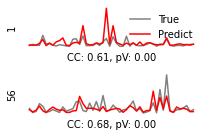

In [16]:
# with regu
tempmodel= VanillaCNN()
tempmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_trainnum_1_Antolik2016Data_trainN__seed_0.pth'))
encoded_np,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
#
nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:,Neurons[ii]],color='r',linestyle='-',label='Predict')
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20211216/Predictive_response_CNN.svg')

(101, 50, 103)
(50, 103)
(50, 103)


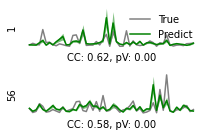

In [15]:
#tempmodel= VariationalCNN()
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_20211216/VariationalCNN_trainnum_1_Antolik2016Data_trainN__seed_0.pth'))
encoded_np,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
encoded_np_std=np.std(encoded_np[:100], axis=0,ddof=1)     #only use sampling numbers 100, not 101
encoded_np    =np.mean(encoded_np[:100],axis=0)
print (encoded_np.shape)
#
nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:,Neurons[ii]],color='g',linestyle='-',label='Predict')
    axes[ii].fill_between(x=np.arange(50),y1=encoded_np[:,Neurons[ii]]+encoded_np_std[:,Neurons[ii]],\
                          y2=encoded_np[:,Neurons[ii]]-encoded_np_std[:,Neurons[ii]],color='g',linewidth=0,alpha=0.5)
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20211216/Predictive_response_VCNN.svg')

(100, 50, 103)
(50, 103)
(50, 103)


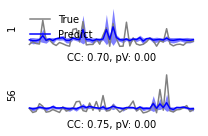

In [16]:
#tempmodel=VanillaCNN_Dropout()
tempmodels=['VanillaCNN_Dropout']
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
model_parameters = {'p':0.7 }
tempmodel = globals()[tempmodels[0]](**model_parameters)
tempmodel.load_state_dict(torch.load('./out_20211216/VanillaCNN_Dropout_trainnum_1_Antolik2016Data_trainN__seed_0.pth'))
encoded_np,y=model_predict_dropout(tempmodel,test_loader,device,drop_out_num=100,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
encoded_np_std=np.std(encoded_np, axis=0,ddof=1)
encoded_np    =np.mean(encoded_np,axis=0)
print (encoded_np.shape)

nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:,Neurons[ii]],color='b',linestyle='-',label='Predict')
    axes[ii].fill_between(x=np.arange(50),y1=encoded_np[:,Neurons[ii]]+encoded_np_std[:,Neurons[ii]],\
                          y2=encoded_np[:,Neurons[ii]]-encoded_np_std[:,Neurons[ii]],color='b',linewidth=0,alpha=0.5)
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20211216/Predictive_response_CNN_MCdropout.svg')

## Uncertainty analysis

#### prediction CC against variance of RF CC

In [12]:
RF_fl_VCNN_np=np.load('out_20211216/Modelcalibration_RF_fl_VCNN.npy')
print(RF_fl_VCNN_np.shape)
print(np.isnan(RF_fl_VCNN_np).any())
print(np.isinf(RF_fl_VCNN_np).any())
print(np.where(~RF_fl_VCNN_np.any(axis=(3,4,5))))

mask = np.all(np.equal(RF_fl_VCNN_np,0), axis=(3,4,5))
RF_fl_VCNN_np= RF_fl_VCNN_np[~mask]
print(RF_fl_VCNN_np.shape)

(10, 101, 103, 1, 31, 31)
False
False
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(104030, 1, 31, 31)


In [30]:
RF_fl_CNN_dropout_np=np.load('out_20211216/Modelcalibration_RF_fl_CNN_dropout.npy')
RFvars2_CNN_dropout=np.var(RF_fl_CNN_dropout_np,axis=1,ddof=1)
RFvars2_CNN_dropout=np.mean(np.mean(np.mean(RFvars2_CNN_dropout,2),2),2)
print(RFvars2_CNN_dropout.shape)
#np.save('out_20211216/Modelcalibration_RFvars2_CNN_MCdropout.npy',RFvars2_CNN_dropout)

(10, 103)


In [113]:
testccs_VCNN=np.load('out_20211216/Modelcalibration_Prediction_CC_against_prediction_var_testccs_VCNN.npy')
testccs_CNN_dropout=np.load('out_20211216/Modelcalibration_Prediction_CC_against_prediction_var_testccs_CNN_MCdropout.npy')
RFvars2_VCNN=np.load('out_20211216/Modelcalibration_RFvars2_VCNN.npy')
RFvars2_CNN_dropout=np.load('out_20211216/Modelcalibration_RFvars2_CNN_MCdropout.npy')

PearsonRResult(statistic=-0.3713362483848731, pvalue=0.0001126083911306766)


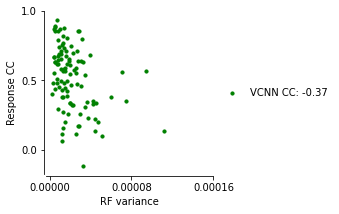

In [114]:
seed_id=1
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
cc0,_=pearsonr(RFvars2_VCNN[seed_id].flatten(),testccs_VCNN[seed_id].flatten())
ax.scatter(RFvars2_VCNN[seed_id].flatten(),testccs_VCNN[seed_id].flatten(),s=10,c='g',label='VCNN CC: {:.2f}'.format(cc0))
print(pearsonr(RFvars2_VCNN[seed_id].flatten(),testccs_VCNN[seed_id].flatten()))

#ax.set_title('Prediction CC against variance of RF CC',fontsize=16)
ax.set_xlabel('RF variance')
ax.set_ylabel('Response CC')
ax.set_xticks([0, 0.00008,0.00016])
ax.set_yticks([0, 0.5, 1.0])
ax.legend(loc='best',frameon=False)
handles, labels = ax.get_legend_handles_labels()
adjust_spines(ax, ['left', 'bottom'])
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/Modelcalibration_PredictionCC_against_variance2_RFcc_VCNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

#### mean response against variance of RF CC

In [98]:
tempmodels= ['VariationalCNN']
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,11)
encodeds_VCNN = np.zeros([len(seeds),101,test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/'+'VariationalCNN_trainnum_1_Antolik2016Data_trainN__seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    encodeds_VCNN[i],_ = model_predict(tempmodel,test_loader,device,sample_num=100)
print(encodeds_VCNN.shape)
#np.save('out_20211216/Modelcalibration_meanresponse_vs_rfvariance_encodeds_10seeds_VCNN.npy',encodeds_VCNN)

(10, 101, 50, 103)


In [101]:
tempmodels= ['VanillaCNN_Dropout']
model_parameters = {'p': 0.7}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,11)
encodeds_CNN_dropout = np.zeros([len(seeds),100,test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/' + 'VanillaCNN_Dropout_trainnum_1_Antolik2016Data_trainN__seed_' + str(i) +'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    encodeds_CNN_dropout[i],_= model_predict_dropout(tempmodel,test_loader,device,drop_out_num=100)
print(encodeds_CNN_dropout.shape)
#np.save('out_20211216/Modelcalibration_meanresponse_vs_rfvariance_encodeds_10seeds_CNN_MCdropout.npy',encodeds_VCNN)

(10, 100, 50, 103)


In [51]:
test_response=test_loader[1]
print(test_response.shape)
test_mean_response=np.mean(test_response,axis=0)
print(test_mean_response.shape)

(50, 103)
(103,)


In [52]:
RFvars2_VCNN=np.load('out_20211216/Modelcalibration_RFvars2_VCNN.npy')
RFvars2_CNN_dropout=np.load('out_20211216/Modelcalibration_RFvars2_CNN_MCdropout.npy')
print(RFvars2_VCNN.shape)

(10, 103)


PearsonRResult(statistic=-0.4749358785068964, pvalue=4.003000107195138e-07)


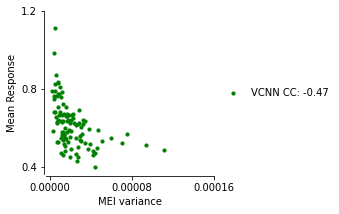

In [127]:
seed_id=1
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
cc0,_=pearsonr(RFvars2_VCNN[seed_id].flatten(),test_mean_response.flatten())
ax.scatter(RFvars2_VCNN[seed_id].flatten(),test_mean_response.flatten(),s=10,c='g',label='VCNN CC: {:.2f}'.format(cc0))
print(pearsonr(RFvars2_VCNN[seed_id].flatten(),test_mean_response.flatten()))

#ax.set_title('Prediction CC against variance of RF CC',fontsize=16)
ax.set_xlabel('MEI variance')
ax.set_ylabel('Mean Response')
ax.set_xticks([0, 0.00008,0.00016])
ax.set_yticks([0.4, 0.8, 1.2])
ax.legend(loc='best',frameon=False)
handles, labels = ax.get_legend_handles_labels()
adjust_spines(ax, ['left', 'bottom'])
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/Modelcalibration_meanresponse_against_variance2_RFcc_VCNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

#### calculate partial correlation

In [22]:
#!pip install pingouin
#!pip install pandas
import pingouin as pg
import pandas as pd

In [23]:
test_response=test_loader[1]
test_mean_response=np.mean(test_response,axis=0)
print(test_mean_response.shape)

(103,)


In [24]:
testccs_VCNN=np.load('out_20211216/Modelcalibration_Prediction_CC_against_prediction_var_testccs_VCNN.npy')
testccs_CNN_dropout=np.load('out_20211216/Modelcalibration_Prediction_CC_against_prediction_var_testccs_CNN_MCdropout.npy')
RFvars2_VCNN=np.load('out_20211216/Modelcalibration_RFvars2_VCNN.npy')
RFvars2_CNN_dropout=np.load('out_20211216/Modelcalibration_RFvars2_CNN_MCdropout.npy')
print (testccs_VCNN.shape)
print(RFvars2_VCNN.shape)

(10, 103)
(10, 103)


In [29]:
seed_id=1
data_VCNN={'testccs_VCNN':testccs_VCNN[seed_id],
      'RFvars2_VCNN':RFvars2_VCNN[seed_id],
      'test_mean_response': test_mean_response  
}
df_VCNN=pd.DataFrame(data_VCNN, columns=['testccs_VCNN','RFvars2_VCNN','test_mean_response'])
pg.partial_corr(data=df_VCNN,x='testccs_VCNN', y='RFvars2_VCNN', covar='test_mean_response')

,n,r,CI95%,p-val
pearson,103,-0.166474,"[-0.35, 0.03]",0.09447


In [30]:
seed_id=1
data_CNN_dropout={'testccs_CNN_dropout':testccs_CNN_dropout[seed_id],
      'RFvars2_CNN_dropout':RFvars2_CNN_dropout[seed_id],
      'test_mean_response': test_mean_response  
}
df_CNN_dropout=pd.DataFrame(data_CNN_dropout, columns=['testccs_CNN_dropout','RFvars2_CNN_dropout','test_mean_response'])
pg.partial_corr(data=df_CNN_dropout,x='testccs_CNN_dropout', y='RFvars2_CNN_dropout', covar='test_mean_response')

,n,r,CI95%,p-val
pearson,103,-0.068158,"[-0.26, 0.13]",0.496077


In [31]:
RFvar_CNN_ensemble = np.load('out_20211216/ensemble_RFvars2_CNN_ensemble.npy')
testccs_ensemble_CNN=np.load('out_20211216/ensemble_Prediction_CC_against_prediction_var_testccs_ensemble_CNN.npy')
print(testccs_ensemble_CNN.shape)

(2, 10, 103)


In [33]:
seed_id=1
data_VCNN={'testccs_ensemble_CNN':testccs_ensemble_CNN[1,seed_id],
      'RFvar_CNN_ensemble':RFvars2_VCNN[1,seed_id],
      'test_mean_response': test_mean_response  
}
df_VCNN=pd.DataFrame(data_VCNN, columns=['testccs_ensemble_CNN','RFvar_CNN_ensemble','test_mean_response'])
pg.partial_corr(data=df_VCNN,x='testccs_ensemble_CNN', y='RFvar_CNN_ensemble', covar='test_mean_response')

,n,r,CI95%,p-val
pearson,103,-0.631942,"[-0.74, -0.5]",1.059301e-12


## ensemble

#### Predictive performance against amount of training data
10 seeds, test data

In [ ]:
tempmodels=['VanillaCNN']  #without regularization
LR=0.0003
EPOCH=200
train_nums=len(train_loader)
alpha_1=0
alpha_2=0
beta=0
vbeta=None
seeds=np.arange(1,51)
test_losses=np.zeros((train_nums, len(seeds)))

for ii in range(len(train_loader)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:(ii+1)],optimizer,device,EPOCH,Ploss_L2L1_SE_regularizaion_2conv,\
                    alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]() #tempmodels[ii]
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_regularization_2conv(tempmodel,train_loader[:(ii+1)],optimizer,device,tempepoch,Ploss_L2L1_SE_regularizaion_2conv,\
                    alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_20211216/'+ tempmodel.__class__.__name__ +\
            'ensemble_noregu__trainnum_' + str(ii)+ '_Antolik2016Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [57]:
#np.save('out_20211216/ensemble_Predictive_performance_against_trainnums_Antolik2016Data_test_losses_CNN_no_regu.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN']              #with regularization
LR=0.0003
EPOCH=200
train_nums=len(train_loader)
alpha_1=1000
alpha_2=0.01
beta=10
vbeta=None
seeds=np.arange(1,51)
test_losses=np.zeros((train_nums, len(seeds)))

for ii in range(len(train_loader)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:(ii+1)],optimizer,device,EPOCH,Ploss_L2L1_SE_regularizaion_2conv,\
                    alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]() #tempmodels[ii]
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_regularization_2conv(tempmodel,train_loader[:(ii+1)],optimizer,device,tempepoch,Ploss_L2L1_SE_regularizaion_2conv,\
                    alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_20211216/'+ tempmodel.__class__.__name__ +\
            'ensemble_trainnum_' + str(ii)+ '_Antolik2016Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [59]:
#np.save('out_20211216/ensemble_Predictive_performance_against_trainnums_Antolik2016Data_test_losses_CNN.npy', test_losses)

In [60]:
tempmodels=['VariationalCNN']
LR=0.0003
EPOCH=200
train_nums=len(train_loader)
alpha=None
beta=None
vbetas=0.1
sampling_number=2
seeds=np.arange(1,51)
test_losses=np.zeros(((train_nums),len(seeds)))
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 0.00247875}

for ii in range(train_nums):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_sample_num(tempmodel,train_loader[:(ii+1)],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False,sampling_num=sampling_number)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_sample_num(tempmodel,train_loader[:(ii+1)],optimizer,device,tempepoch,Ploss_L2L1_SE,\
                alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False,sampling_num=sampling_number)
        torch.save(tempmodel.state_dict(), './out_20211216/'+ tempmodel.__class__.__name__ +\
            'ensemble_trainnum_' + str(ii) + '_Antolik2016Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

2023-08-04 19:59:18.714907
Epoch: 199 val loss: 0.2364, finish training!
2023-08-04 19:59:41.689715
2023-08-04 19:59:41.766499
Epoch: 196 val loss: 0.2450, finish training!
2023-08-04 20:00:04.641210
Test loss: 0.5090056526814547

2023-08-04 20:00:04.845154
Epoch: 199 val loss: 0.2254, finish training!
2023-08-04 20:00:27.248344
2023-08-04 20:00:27.302768
Epoch: 197 val loss: 0.2325, finish training!
2023-08-04 20:00:48.753394
Test loss: 0.5234171024996848

2023-08-04 20:00:48.978438
Epoch: 199 val loss: 0.2258, finish training!
2023-08-04 20:01:12.151874
2023-08-04 20:01:12.213459
Epoch: 171 val loss: 0.2385, finish training!
2023-08-04 20:01:31.140953
Test loss: 0.5514790509094528

2023-08-04 20:01:31.363090
Epoch: 199 val loss: 0.2378, finish training!
2023-08-04 20:01:53.378664
2023-08-04 20:01:53.459390
Epoch: 190 val loss: 0.2406, finish training!
2023-08-04 20:02:14.466113
Test loss: 0.5329792922557618

2023-08-04 20:02:14.692530
Epoch: 199 val loss: 0.2171, finish training!
202

In [61]:
#np.save('out_20211216/ensemble_Predictive_performance_against_trainnums_Antolik2016Data_test_losses.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN_Dropout']
LR=0.0003
EPOCH=200
train_nums=len(train_loader)
alpha=0
beta=0
vbetas=None
drop_out_num=100
model_parameters = {'p':0.7}
seeds=np.arange(1,51)
test_losses=np.zeros(((train_nums),len(seeds)))

for ii in range(train_nums):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_drop_out(tempmodel,train_loader[:(ii+1)],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    drop_out_num,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_drop_out(tempmodel,train_loader[:(ii+1)],optimizer,device,tempepoch,Ploss_L2L1_SE,\
                drop_out_num,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_20211216/'+ tempmodel.__class__.__name__ +\
             'ensemble_v1_trainnum_' + str(ii) + '_Antolik2016Data_trainN_'+ '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val_drop_out(tempmodel,test_loader,device,drop_out_num,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [ ]:
#np.save('out_20211216/ensemble_CNN_dropout_Antolik2016Data_test_losses.npy', test_losses)

In [47]:
tempmodel= VanillaCNN()
seeds=np.arange(1,51)
encodeds_CNN = np.zeros([2,len(seeds),test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(2):
    for j in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_20211216/'+'VanillaCNNensemble_noregu__trainnum_'+str(i)+'_Antolik2016Data_trainN__seed_'+str(j)+'.pth'))
        torch.manual_seed(seeds[j])    # reproducible
        torch.cuda.manual_seed(seeds[j])
        encodeds_CNN[i,j],_ = model_predict(tempmodel,test_loader,device,sample_num=100)
#np.save('out_20211216/ensemble_Modelcalibration_encodeds_50seeds_CNN_no_regu.npy',encodeds_CNN)

In [48]:
tempmodel= VanillaCNN()
seeds=np.arange(1,51)
encodeds_CNN = np.zeros([2,len(seeds),test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(2):
    for j in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_20211216/'+'VanillaCNNensemble_trainnum_'+str(i)+'_Antolik2016Data_trainN__seed_'+str(j)+'.pth'))
        torch.manual_seed(seeds[j])    # reproducible
        torch.cuda.manual_seed(seeds[j])
        encodeds_CNN[i,j],_ = model_predict(tempmodel,test_loader,device,sample_num=100)
#np.save('out_20211216/ensemble_Modelcalibration_encodeds_50seeds_CNN.npy',encodeds_CNN)

In [49]:
tempmodels= ['VariationalCNN']
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,11)
encodeds_VCNN = np.zeros([2,len(seeds),101,test_loader[1].shape[0],test_loader[1].shape[1]])
encodeds_groundtruth = np.zeros([2,len(seeds),test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(2):
    for j in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_20211216/'+'VariationalCNNensemble_trainnum_'+str(i)+'_Antolik2016Data_trainN__seed_'+str(j)+'.pth'))
        torch.manual_seed(seeds[j])    # reproducible
        torch.cuda.manual_seed(seeds[j])
        encodeds_VCNN[i,j],encodeds_groundtruth[i,j]= model_predict(tempmodel,test_loader,device,sample_num=100)
# np.save('out_20211216/ensemble_Modelcalibration_encodeds_10seeds_VCNN.npy',encodeds_VCNN)
# np.save('out_20211216/ensemble_Modelcalibration_encodeds_groundtruth.npy',encodeds_groundtruth)

In [50]:
tempmodels= ['VanillaCNN_Dropout']
model_parameters = {'p': 0.7}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,11)
encodeds_CNN_dropout = np.zeros([2,len(seeds),100,test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(2):
    for j in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_20211216/' + 'VanillaCNN_Dropoutensemble_v1_trainnum_'+str(i)+'_Antolik2016Data_trainN__seed_' + str(j) +'.pth'))
        torch.manual_seed(seeds[j])    # reproducible
        torch.cuda.manual_seed(seeds[j])
        encodeds_CNN_dropout[i,j],_= model_predict_dropout(tempmodel,test_loader,device,drop_out_num=100)
#np.save('out_20211216/ensemble_Modelcalibration_encodeds_10seeds_CNN_dropout.npy', encodeds_CNN_dropout)

In [18]:
class VanillaCNN_MAP(nn.Module):
    def __init__(self,numoffea=48, PI=0.5, SIGMA_1=1, SIGMA_2=0.00247875):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=17*17 #size of feature
        self.numofneuron=103 #number of neurons
        #
        self.conv1 = nn.Conv2d(1,24,kernel_size=9,stride=1)#24,23*23
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(24,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(24*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
    def forward(self, x, calculate_log_probs=False):
        encoded = F.relu(self.conv1(x))#24,23*23
        encoded = F.relu(self.conv2(encoded))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded)) #use exp instead of relu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(self.conv1.weight) + \
                             self.weight_prior.log_prob(self.conv2.weight) + \
                             self.weight_prior.log_prob(self.fc1.weight) + \
                             self.bias_prior.log_prob(self.conv1.bias) + \
                             self.bias_prior.log_prob(self.conv2.bias) + \
                             self.bias_prior.log_prob(self.fc1.bias)
        else:
            self.log_prior = 0
        return encoded, self.log_prior

In [ ]:
tempmodels= ['VanillaCNN_MAP']
model_parameters = {'PI': 0.5, 'SIGMA_1':0.02 , 'SIGMA_2': 0.02}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,11)
encodeds_CNN_map = np.zeros([2,len(seeds),test_loader[1].shape[0],test_loader[1].shape[1]])
encodeds_groundtruth = np.zeros([2,len(seeds),test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(2):
    for j in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./temp/'+'VanillaCNN_MAP_20211216_map_siga1002_sigma002_trainnum_'+str(i)+'_Antolik2016Data_trainN__seed_'+str(j)+'.pth'))
        torch.manual_seed(seeds[j])    # reproducible
        torch.cuda.manual_seed(seeds[j])
        encodeds_CNN_map[i,j],_= model_predict_map(tempmodel,test_loader,device,sample_num=100)
#np.save('out_20211216/CNN_MAP_Modelcalibration_encodeds_10seeds_VCNN.npy',encodeds_CNN_map)

In [18]:
encodeds_CNN_noregu=np.load('out_20211216/ensemble_Modelcalibration_encodeds_50seeds_CNN_no_regu.npy')
encodeds_CNN=np.load('out_20211216/ensemble_Modelcalibration_encodeds_50seeds_CNN.npy')
encodeds_VCNN=np.load('out_20211216/ensemble_Modelcalibration_encodeds_10seeds_VCNN.npy')
encodeds_CNN_dropout=np.load('out_20211216/ensemble_Modelcalibration_encodeds_10seeds_CNN_dropout.npy')
encodeds_groundtruth=np.load('out_20211216/ensemble_Modelcalibration_encodeds_groundtruth.npy')
encodeds_CNN_map=np.load('out_20211216/CNN_MAP_Modelcalibration_encodeds_10seeds_VCNN.npy')
print(encodeds_CNN.shape)
print(encodeds_VCNN.shape)
print(encodeds_CNN_map.shape)
print(encodeds_CNN_dropout.shape)
print(encodeds_groundtruth.shape)

(2, 50, 50, 103)
(2, 10, 101, 50, 103)
(2, 10, 50, 103)
(2, 10, 100, 50, 103)
(2, 10, 50, 103)


In [19]:
encodeds_VCNN_mean=np.mean(encodeds_VCNN[:,:,0:100],axis=2)
encodeds_CNN_dropout_mean=np.mean(encodeds_CNN_dropout[:,:,0:100],axis=2)
print(encodeds_VCNN_mean.shape)
print(encodeds_CNN_dropout_mean.shape)

(2, 10, 50, 103)
(2, 10, 50, 103)


In [20]:
encodeds_CNN_noregu_ensemble=np.zeros([2,10,50,103])
for i in range(2):
    for j in range(10):
        encodeds_CNN_noregu_ensemble[i,j]=np.mean(encodeds_CNN_noregu[i,j*5:j*5+5],axis=0)

encodeds_CNN_ensemble=np.zeros([2,10,50,103])
for i in range(2):
    for j in range(10):
        encodeds_CNN_ensemble[i,j]=np.mean(encodeds_CNN[i,j*5:j*5+5],axis=0)
#np.save('out_20211216/ensemble_Modelcalibration_encodeds_10seeds_CNN_ensemble.npy',encodeds_CNN_ensemble)
        
# encodeds_VCNN_ensemble=np.zeros([2,10,50,103])
# for i in range(2):
#     for j in range(10):
#         encodeds_VCNN_ensemble[i,j]=np.mean(encodeds_VCNN_mean[i,j*5:j*5+5],axis=0)
        
# encodeds_CNN_dropout_ensemble=np.zeros([2,10,50,103])
# for i in range(2):
#     for j in range(10):
#         encodeds_CNN_dropout_ensemble[i,j]=np.mean(encodeds_CNN_dropout_mean[i,j*5:j*5+5],axis=0)

In [21]:
testcc_eCNN_noregu=np.zeros([2,10])
testpvalue_eCNN_noregu=np.zeros([2,10])
for i in range(2):
    for j in range(10):
        testcc_eCNN_noregu[i,j],testpvalue_eCNN_noregu[i,j]=pearsonr(encodeds_CNN_noregu_ensemble[i,j].flatten(), encodeds_groundtruth[i,j].flatten())

testcc_eCNN=np.zeros([2,10])
testpvalue_eCNN=np.zeros([2,10])
for i in range(2):
    for j in range(10):
        testcc_eCNN[i,j],testpvalue_eCNN[i,j]=pearsonr(encodeds_CNN_ensemble[i,j].flatten(), encodeds_groundtruth[i,j].flatten())

testcc_CNN_noregu=np.zeros([2,10])
testpvalue_CNN_noregu=np.zeros([2,10])
for i in range(2):
    for j in range(10):
        testcc_CNN_noregu[i,j],testpvalue_CNN_noregu[i,j]=pearsonr(encodeds_CNN_noregu[i,j].flatten(), encodeds_groundtruth[i,j].flatten())
        
testcc_CNN=np.zeros([2,10])
testpvalue_CNN=np.zeros([2,10])
for i in range(2):
    for j in range(10):
        testcc_CNN[i,j],testpvalue_CNN[i,j]=pearsonr(encodeds_CNN[i,j].flatten(), encodeds_groundtruth[i,j].flatten())
        
testcc_VCNN=np.zeros([2,10])
testpvalue_VCNN=np.zeros([2,10])
for i in range(2):
    for j in range(10):
        testcc_VCNN[i,j],testpvalue_VCNN[i,j]=pearsonr(encodeds_VCNN_mean[i,j].flatten(), encodeds_groundtruth[i,j].flatten())
        
testcc_CNN_dropout=np.zeros([2,10])
testpvalue_CNN_dropout=np.zeros([2,10])
for i in range(2):
    for j in range(10):
        testcc_CNN_dropout[i,j],testpvalue_CNN_dropout[i,j]=pearsonr(encodeds_CNN_dropout_mean[i,j].flatten(), encodeds_groundtruth[i,j].flatten())
        
testcc_CNN_map=np.zeros([2,10])
testpvalue_CNN_map=np.zeros([2,10])
for i in range(2):
    for j in range(10):
        testcc_CNN_map[i,j],testpvalue_CNN_map[i,j]=pearsonr(encodeds_CNN_map[i,j].flatten(), encodeds_groundtruth[i,j].flatten())

In [22]:
testcc_eCNN_noregu_mean=np.mean(testcc_eCNN_noregu,axis=1)
testcc_eCNN_noregu_std =np.std (testcc_eCNN_noregu,axis=1,ddof=1)

testcc_eCNN_mean=np.mean(testcc_eCNN,axis=1)
testcc_eCNN_std=np.std(testcc_eCNN,axis=1,ddof=1)

testcc_CNN_noregu_mean=np.mean(testcc_CNN_noregu,axis=1)
testcc_CNN_noregu_std =np.std (testcc_CNN_noregu,axis=1,ddof=1)

testcc_CNN_mean=np.mean(testcc_CNN,axis=1)
testcc_CNN_std=np.std(testcc_CNN,axis=1,ddof=1)

testcc_VCNN_mean=np.mean(testcc_VCNN,axis=1)
testcc_VCNN_std=np.std(testcc_VCNN,axis=1,ddof=1)

testcc_CNN_dropout_mean=np.mean(testcc_CNN_dropout,axis=1)
testcc_CNN_dropout_std=np.std(testcc_CNN_dropout,axis=1,ddof=1)

testcc_CNN_map_mean=np.mean(testcc_CNN_map,axis=1)
testcc_CNN_map_std=np.std(testcc_CNN_map,axis=1,ddof=1)

In [23]:
#permutation test
#https://stackoverflow.com/questions/24795535/pythons-implementation-of-permutation-test-with-permutation-number-as-input
#permutation test using monte-carlo method
def perm_test(xs, ys, nmc, randomseed):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
def perm_test_group(list_of_array,nmc=10000,randomseed=66):
    perm_res=[]
    for ii in np.arange(len(list_of_array)):
        for jj in np.arange(ii+1,len(list_of_array)):
            temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
            perm_res.append(temp)
    return perm_res
#
print('50% of training data\n')
print ('Baseline：',perm_test(testcc_VCNN[0],testcc_CNN_noregu[0],nmc=10000,randomseed=66))
print ('Ensemble: ',perm_test(testcc_VCNN[0],testcc_eCNN[0],nmc=10000,randomseed=66))
print ('L2+L1: ', perm_test(testcc_VCNN[0],testcc_CNN[0],nmc=10000,randomseed=66))
print ('MC dropout: ', perm_test(testcc_VCNN[0],testcc_CNN_dropout[0],nmc=10000,randomseed=66))
print ('Map: ', perm_test(testcc_VCNN[0],testcc_CNN_map[0],nmc=10000,randomseed=66))

print('\n100% of training data\n')
print ('Baseline：',perm_test(testcc_VCNN[1],testcc_CNN_noregu[1],nmc=10000,randomseed=66))
print ('Ensemble: ',perm_test(testcc_VCNN[1],testcc_eCNN[1],nmc=10000,randomseed=66))
print ('L2+L1: ', perm_test(testcc_VCNN[1],testcc_CNN[1],nmc=10000,randomseed=66))
print ('MC dropout: ', perm_test(testcc_VCNN[1],testcc_CNN_dropout[1],nmc=10000,randomseed=66))
print ('Map: ', perm_test(testcc_VCNN[1],testcc_CNN_map[1],nmc=10000,randomseed=66))

50% of training data

Baseline： 0.028
Ensemble:  0.0043
L2+L1:  0.0009
MC dropout:  0.082
Map:  0.2526

100% of training data

Baseline： 0.0001
Ensemble:  0.013
L2+L1:  0.0007
MC dropout:  0.6159
Map:  0.0001


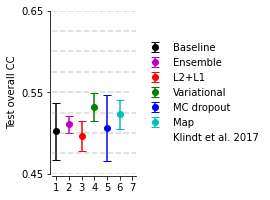

In [33]:
templabels=['1','2','3','4','5','6','7']  
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(1.5,3))
#ax.axhline(y=0.84,color='k',linestyle=':') #upper bound
# ax.errorbar(np.arange(len(train_nums)),testcc_eCNN_noregu_mean,yerr=testcc_eCNN_noregu_std,\
#             marker='o', color='c',linestyle='-',label='eCNN_noregu',alpha=1, capsize=4)
i=0

ax.errorbar(0,testcc_CNN_noregu_mean[i],yerr=testcc_CNN_noregu_std[i],\
            marker='o', color='k',linestyle='None',label='Baseline',alpha=1, capsize=4)
ax.errorbar(1,testcc_eCNN_mean[i],yerr=testcc_eCNN_std[i],\
            marker='o', color='m',linestyle='None',label='Ensemble',alpha=1, capsize=4)
ax.errorbar(2,testcc_CNN_mean[i],yerr=testcc_CNN_std[i],\
            marker='o', color='r',linestyle='None',label='L2+L1',alpha=1, capsize=4)
ax.errorbar(3,testcc_VCNN_mean[i],yerr=testcc_VCNN_std[i],\
            marker='o', color='g',linestyle='None',label='Variational',alpha=1, capsize=4)
ax.errorbar(4,testcc_CNN_dropout_mean[i],yerr=testcc_CNN_dropout_std[i],\
            marker='o', color='b',linestyle='None',label='MC dropout',alpha=1, capsize=4)
ax.errorbar(5,testcc_CNN_map_mean[i],yerr=testcc_CNN_map_std[i],\
            marker='o', color='c',linestyle='None',label='Map',alpha=1, capsize=4)
ax.errorbar(6,0.55,0.1,color='1',linestyle='None',marker='o',label='Klindt et al. 2017')

ax.set_xticks(np.arange(7).tolist())
ax.set_yticks([0.45,0.55,0.65])
ax.set_ylim(ymin=0.45,ymax=0.65)
ax.set_xticklabels(templabels)

y_positions = np.arange(0.45,0.7,0.025)
for y in y_positions:
    ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)

#ax.set_xlabel('Training data')
ax.set_ylabel('Test overall CC')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/ennsemble_Predictive_performance_against_trainingSize0_testCC.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

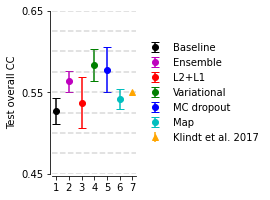

In [34]:
templabels=['1','2','3','4','5','6','7']  
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(1.5,3))
#ax.axhline(y=0.84,color='k',linestyle=':') #upper bound
# ax.errorbar(np.arange(len(train_nums)),testcc_eCNN_noregu_mean,yerr=testcc_eCNN_noregu_std,\
#             marker='o', color='c',linestyle='-',label='eCNN_noregu',alpha=1, capsize=4)
i=1

ax.errorbar(0,testcc_CNN_noregu_mean[i],yerr=testcc_CNN_noregu_std[i],\
            marker='o', color='k',linestyle='None',label='Baseline',alpha=1, capsize=4)
ax.errorbar(1,testcc_eCNN_mean[i],yerr=testcc_eCNN_std[i],\
            marker='o', color='m',linestyle='None',label='Ensemble',alpha=1, capsize=4)
ax.errorbar(2,testcc_CNN_mean[i],yerr=testcc_CNN_std[i],\
            marker='o', color='r',linestyle='None',label='L2+L1',alpha=1, capsize=4)
ax.errorbar(3,testcc_VCNN_mean[i],yerr=testcc_VCNN_std[i],\
            marker='o', color='g',linestyle='None',label='Variational',alpha=1, capsize=4)
ax.errorbar(4,testcc_CNN_dropout_mean[i],yerr=testcc_CNN_dropout_std[i],\
            marker='o', color='b',linestyle='None',label='MC dropout',alpha=1, capsize=4)
ax.errorbar(5,testcc_CNN_map_mean[i],yerr=testcc_CNN_map_std[i],\
            marker='o', color='c',linestyle='None',label='Map',alpha=1, capsize=4)
ax.errorbar(6,0.55,0,color='orange',linestyle='None',marker='^',label='Klindt et al. 2017')

ax.set_xticks(np.arange(7).tolist())
ax.set_yticks([0.45,0.55,0.65])
ax.set_ylim(ymin=0.45,ymax=0.65)
ax.set_xticklabels(templabels)

y_positions = np.arange(0.45,0.7,0.025)
for y in y_positions:
    ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
    
    
#ax.set_xlabel('Training data')
ax.set_ylabel('Test overall CC')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/ennsemble_Predictive_performance_against_trainingSize1_testCC.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

#### prediction CC against variance of RF CC

In [208]:
RF_fl_CNN_ensemble_50seeds = np.load('out_20211216/ensembe_RF_fl_CNN_50seeds.npy')
print(RF_fl_CNN_ensemble_50seeds.shape)
RFvar_CNN_ensemble=np.zeros([2,10,103])
for i in range(2):
    for j in range(10):
        temp=np.var(RF_fl_CNN_ensemble_50seeds[i,j*5:j*5+5],axis=0,ddof=1)
        RFvar_CNN_ensemble[i,j]=np.mean(np.mean(np.mean(temp,1),1),1)
print(RFvar_CNN_ensemble.shape)
#np.save('out_20211216/ensemble_RFvars2_CNN_ensemble.npy',RFvar_CNN_ensemble)

(2, 50, 103, 1, 31, 31)
(2, 10, 103)


In [209]:
test_response=test_loader[1]
print(test_response.shape)
encodeds_CNN=np.load('out_20211216/ensemble_Modelcalibration_encodeds_50seeds_CNN.npy')
print(encodeds_CNN.shape)
testccs_ensemble_CNN = np.zeros([2,10,103])
pvalue_ensemble_CNN = np.zeros([2,10,103])

for i in range(2):
    for j in range(10):
        temp=np.mean(encodeds_CNN[i,j*5:j*5+5],0)
        for k in range(103):
            testccs_ensemble_CNN[i,j,k], pvalue_ensemble_CNN[i,j,k] = pearsonr(temp[:,k].flatten(), test_response[:,k].flatten())  
#np.save('out_20211216/ensemble_Prediction_CC_against_prediction_var_testccs_ensemble_CNN.npy',testccs_ensemble_CNN)

(50, 103)
(2, 50, 50, 103)


In [211]:
print(np.percentile(pvalue_ensemble_CNN[1],70))

0.012618905619298987


In [183]:
RFvar_CNN_ensemble = np.load('out_20211216/ensemble_RFvars2_CNN_ensemble.npy')
testccs_ensemble_CNN=np.load('out_20211216/ensemble_Prediction_CC_against_prediction_var_testccs_ensemble_CNN.npy')
print(RFvar_CNN_ensemble.shape)
print(testccs_ensemble_CNN.shape)
print(np.isnan(RFvar_CNN_ensemble).any())
print(np.isinf(RFvar_CNN_ensemble).any())

(2, 10, 103)
(2, 10, 103)
False
False


#### Prediction CC against variance of prediction CC

In [219]:
test_response=test_loader[1]
print(test_response.shape)
encodeds_CNN=np.load('out_20211216/ensemble_Modelcalibration_encodeds_50seeds_CNN.npy')
print(encodeds_CNN.shape)
testvars2 = np.zeros([2,10,103])

for i in range(2):
    for j in range(10):
        temp=np.var(encodeds_CNN[i,j*5:j*5+5],axis=0, ddof=1)
        testvars2[i,j]=np.mean(temp, axis=0)
#np.save('out_20211216/ensemble_Prediction_CC_against_prediction_var_testvars2_ensemble_CNN.npy',testvars2)

(50, 103)
(2, 50, 50, 103)


In [221]:
testvar_CNN_ensemble = np.load('out_20211216/ensemble_Prediction_CC_against_prediction_var_testvars2_ensemble_CNN.npy')
testccs_ensemble_CNN=np.load('out_20211216/ensemble_Prediction_CC_against_prediction_var_testccs_ensemble_CNN.npy')
print(testvar_CNN_ensemble.shape)
print(testccs_ensemble_CNN.shape)

(2, 10, 103)
(2, 10, 103)


In [ ]:
tempmodels= ['VariationalCNN']
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,11)
testccs_VCNN = np.zeros([len(seeds),test_loader[1].shape[1]])
testvars_VCNN = np.zeros([len(seeds),test_loader[1].shape[1]])
testvars2_VCNN = np.zeros([len(seeds),test_loader[1].shape[1]])
for i in range(len(seeds)):
    tempmodel.load_state_dict(torch.load('./out_20211216/'+'VariationalCNN_trainnum_1_Antolik2016Data_trainN__seed_'+str(i)+'.pth'))
    torch.manual_seed(seeds[i])    # reproducible
    torch.cuda.manual_seed(seeds[i])
    testccs_VCNN[i], testvars_VCNN[i],testvars2_VCNN[i]= model_test_save(tempmodel,test_loader,device,sample_mean_Flag=False, sample_num=100)

In [213]:
testccs_ensemble_CNN=np.load('out_20211216/ensemble_Prediction_CC_against_prediction_var_testccs_ensemble_CNN.npy')
print(testccs_ensemble_CNN.shape)

(2, 10, 103)


#### mean response against variance of RF CC

In [196]:
test_response=test_loader[1]
print(test_response.shape)
test_mean_response=np.mean(test_response,axis=0)
print(test_mean_response.shape)

(50, 103)
(103,)


In [197]:
RFvar_CNN_ensemble = np.load('out_20211216/ensemble_RFvars2_CNN_ensemble.npy')
print(RFvar_CNN_ensemble.shape)

(2, 10, 103)


PearsonRResult(statistic=-0.3304967400879616, pvalue=0.0006506344064023855)


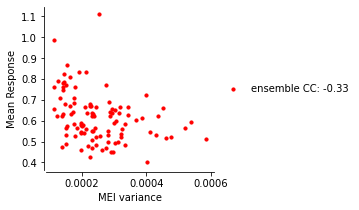

In [207]:
seed_id=0
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
cc0,_=pearsonr(RFvar_CNN_ensemble[1,seed_id].flatten(),test_mean_response.flatten())
ax.scatter(RFvar_CNN_ensemble[1,seed_id].flatten(),test_mean_response.flatten(),s=10,c='r',label='ensemble CC: {:.2f}'.format(cc0))
print(pearsonr(RFvar_CNN_ensemble[1,seed_id].flatten(),test_mean_response.flatten()))

#ax.set_title('Prediction CC against variance of RF CC',fontsize=16)
ax.set_xlabel('MEI variance')
ax.set_ylabel('Mean Response')
# ax.set_xticks([0, 0.00008,0.00016])
# ax.set_yticks([0.4, 0.8, 1.2])
ax.legend(loc='best',frameon=False)
handles, labels = ax.get_legend_handles_labels()
adjust_spines(ax, ['left', 'bottom'])
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/ensemble_Modelcalibration_meanresponse_against_variance2_RFcc_ensemble_CNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')